In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import scipy.io as sio
import pandas as pd
import time
import cv2
from skimage.transform import resize
from IPython.display import clear_output
os.system('pip install tensorflow-addons')

0

In [ ]:
def one_hot(vec):
  items=np.sort(pd.unique(vec))
  n_class=np.shape(items)[0]
  zeros=np.zeros((vec.size, n_class))
  for n,i in enumerate(items):
    rows=np.where(vec==i)[0]
    zeros[rows,n]=1
  return zeros.astype('float32'), n_class

In [ ]:
def get_index(vec_lab, seed=1996, split_train=0.6, validation=False):
  train=[]
  valid=[]
  test =[]

  spv=(1-split_train)/2.
  for i in range(2):
    ind_clss=np.where(vec_lab[:,i]==1)[0]
    sz=len(ind_clss)
    np.random.seed(seed)
    ramd=np.random.choice(sz, sz, replace=False)
    train=np.append(train, ind_clss[ramd[:int(sz*split_train)]])
    valid=np.append(valid, ind_clss[ramd[int(sz*split_train):int(sz*(split_train+spv))]])
    test =np.append(test, ind_clss[ramd[int(sz*(split_train+spv)):]])
  train=train[np.random.choice(len(train), len(train), replace=False)].astype('int')
  valid=valid[np.random.choice(len(valid), len(valid), replace=False)].astype('int')
  test= test[np.random.choice(len(test), len(test), replace=False)].astype('int')
  if validation:
    return train, valid, test
  else:
    return np.concatenate((train,valid)), test

In [ ]:
def augmentation_f(data, labx):
  images=tf.concat([data,
                  tf.image.rot90(data, 1),
                  tf.image.rot90(data, 2),
                  tf.image.rot90(data, 3)], 0)
  lab=tf.concat([labx,labx,labx,labx], 0)
  sc=np.shape(images)[0]
  idr=np.random.choice(sc,sc,replace=False)
  images=tf.convert_to_tensor(np.array(images)[idr])
  lab=tf.convert_to_tensor(np.array(lab)[idr])
  return images, lab

In [ ]:
def get_data_training(indx, ima_tens, labels_v, k_fold='none', number_folds=10, augm=False):
  if k_fold!='none':
    sz=len(indx)/number_folds
    valid=indx[int(k_fold*sz):int((k_fold+1)*sz)]
    train=np.concatenate((indx[:int(k_fold*sz)],indx[int((k_fold+1)*sz):])) 

    x_data=tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.array(ima_tens)[train]))
    v_data=tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.array(ima_tens)[valid]))
    y_data=tf.convert_to_tensor(np.array(labels_v)[train])
    vy_dat=tf.convert_to_tensor(np.array(labels_v)[valid])

    if augm:
      x_data, y_data=augmentation_f(x_data, y_data)
      v_data, vy_dat=augmentation_f(v_data, vy_dat)

    return x_data, v_data, y_data, vy_dat
  else:
    x_data=tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.array(ima_tens)[indx]))
    y_data=tf.convert_to_tensor(np.array(labels_v)[indx])
    if augm:
      x_data, y_data=augmentation_f(x_data, y_data)
    return x_data, y_data

In [ ]:
def get_data(sequences='T1'): #'FLAIR','T1_Gd'
  data_dir=('/content/drive/MyDrive/Brain_tumors_v2/Datasets/TCIA_LGG/x_x.mat')
  mats=sio.loadmat(data_dir.replace('x_x', sequences))
  images=mats['images']
  images=images.reshape((np.shape(images)[0],np.shape(images)[1],np.shape(images)[2],1))
  labels=(mats['size_tumor'][0]!=0).astype('int')
  images=tf.image.resize(images, [240,240], method='nearest')
  labels, n_class=one_hot(labels)
  return images, labels, n_class

In [ ]:
from tensorflow.keras import applications as ap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
df = pd.DataFrame(columns=('run_n', 'k_fold', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time', 'transfer', 'augm', 'Class', 'TP', 'TN', 'FP', 'FN','result_mat'))
df.head()

,run_n,k_fold,network,optimizer,loss,epochs,total_parameters,time,transfer,augm,Class,TP,TN,FP,FN,result_mat


In [ ]:
TP=tf.keras.metrics.TruePositives()
TN=tf.keras.metrics.TrueNegatives()
FP=tf.keras.metrics.FalsePositives()
FN=tf.keras.metrics.FalseNegatives()

In [ ]:
seq='FLAIR'#,
imas, labs, no_cls=get_data(seq)

train_id, test_id=get_index(labs)
x_train, y_trai=get_data_training(train_id, imas, labs)
x_test, y_test0=get_data_training(test_id,  imas, labs)

num_classes = np.shape(y_trai)[1]
input_shape = np.shape(x_train)[1:]

y_train=np.argmax(y_trai, axis=1).reshape(np.shape(y_trai)[0],1)
y_test=np.argmax(y_test0, axis=1).reshape(np.shape(y_test0)[0],1)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))

(3142, 240, 240, 3) (3142, 1)
(787, 240, 240, 3) (787, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


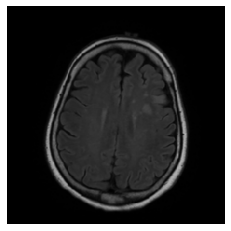

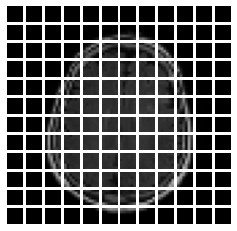

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras import constraints
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.utils import tf_utils
import string
from tensorflow.python.keras.layers import einsum_dense
from tensorflow.python.keras.layers import advanced_activations
from tensorflow.python.keras.layers import core
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import special_math_ops
from tensorflow.python.util.tf_export import keras_export

In [ ]:
def _build_proj_equation(free_dims, bound_dims, output_dims):
  input_str = ""
  kernel_str = ""
  output_str = ""
  bias_axes = ""
  letter_offset = 0
  for i in range(free_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    output_str += char

  letter_offset += free_dims
  for i in range(bound_dims):
    char = _CHR_IDX[i + letter_offset]
    input_str += char
    kernel_str += char

  letter_offset += bound_dims
  for i in range(output_dims):
    char = _CHR_IDX[i + letter_offset]
    kernel_str += char
    output_str += char
    bias_axes += char
  equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

  return equation, bias_axes, len(output_str)

In [ ]:
def _get_output_shape(output_rank, known_last_dims):
  return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)

In [ ]:
def _build_attention_equation(rank, attn_axes):
  target_notation = _CHR_IDX[:rank]
  batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
  letter_offset = rank
  source_notation = ""
  for i in range(rank):
    if i in batch_dims or i == rank - 1:
      source_notation += target_notation[i]
    else:
      source_notation += _CHR_IDX[letter_offset]
      letter_offset += 1

  product_notation = "".join([target_notation[i] for i in batch_dims] +
                             [target_notation[i] for i in attn_axes] +
                             [source_notation[i] for i in attn_axes])
  dot_product_equation = "%s,%s->%s" % (source_notation, target_notation,
                                        product_notation)
  attn_scores_rank = len(product_notation)
  combine_equation = "%s,%s->%s" % (product_notation, source_notation,
                                    target_notation)
  return dot_product_equation, combine_equation, attn_scores_rank

In [ ]:
_CHR_IDX = string.ascii_lowercase

In [ ]:
@keras_export("keras.layers.MultiHeadAttention2")
class MultiHeadAttention2(Layer):
  """MultiHeadAttention layer.
  Nulti-head attention mechanism with the attention mechanism focused
  on the query, keys and values. The attention mechanism is crossed to 
  avoid loss of information in dimension reduction by scalar product."""

  def __init__(self,
               num_heads,
               key_dim,
               value_dim=None,
               dropout=0.0,
               use_bias=True,
               output_shape=None,
               attention_axes=None,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(MultiHeadAttention2, self).__init__(**kwargs)
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim if value_dim else key_dim
    self._dropout = dropout
    self._use_bias = use_bias
    self._output_shape = output_shape
    self._kernel_initializer = initializers.get(kernel_initializer)
    self._bias_initializer = initializers.get(bias_initializer)
    self._kernel_regularizer = regularizers.get(kernel_regularizer)
    self._bias_regularizer = regularizers.get(bias_regularizer)
    self._kernel_constraint = constraints.get(kernel_constraint)
    self._bias_constraint = constraints.get(bias_constraint)
    if attention_axes is not None and not isinstance(attention_axes,
                                                     collections.abc.Sized):
      self._attention_axes = (attention_axes,)
    else:
      self._attention_axes = attention_axes
    self._built_from_signature = False
    self._query_shape, self._key_shape, self._value_shape = None, None, None

  def get_config(self):
    config = {
        "num_heads":
            self._num_heads,
        "key_dim":
            self._key_dim,
        "value_dim":
            self._value_dim,
        "dropout":
            self._dropout,
        "use_bias":
            self._use_bias,
        "output_shape":
            self._output_shape,
        "attention_axes":
            self._attention_axes,
        "kernel_initializer":
            initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            constraints.serialize(self._bias_constraint),
        "query_shape": self._query_shape,
        "key_shape": self._key_shape,
        "value_shape": self._value_shape,
    }
    base_config = super(MultiHeadAttention2, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    query_shape = config.pop("query_shape")
    key_shape = config.pop("key_shape")
    value_shape = config.pop("value_shape")
    layer = cls(**config)
    if None in [query_shape, key_shape, value_shape]:
      logging.warning(
          "One of the input shape is missing. They should be "
          "memorized when the layer was serialized. "
          "%s is created without weights.",
          str(cls))
    else:
      layer._build_from_signature(query_shape, value_shape, key_shape)  # pylint: disable=protected-access
    return layer

  def _build_from_signature(self, query, value, key=None):
    self._built_from_signature = True
    if hasattr(query, "shape"):
      self._query_shape = tensor_shape.TensorShape(query.shape)
    else:
      self._query_shape = tensor_shape.TensorShape(query)
    if hasattr(value, "shape"):
      self._value_shape = tensor_shape.TensorShape(value.shape)
    else:
      self._value_shape = tensor_shape.TensorShape(value)
    if key is None:
      self._key_shape = self._value_shape
    elif hasattr(key, "shape"):
      self._key_shape = tensor_shape.TensorShape(key.shape)
    else:
      self._key_shape = tensor_shape.TensorShape(key)

    common_kwargs = dict(
        kernel_initializer=self._kernel_initializer,
        bias_initializer=self._bias_initializer,
        kernel_regularizer=self._kernel_regularizer,
        bias_regularizer=self._bias_regularizer,
        activity_regularizer=self._activity_regularizer,
        kernel_constraint=self._kernel_constraint,
        bias_constraint=self._bias_constraint)

    with tf_utils.maybe_init_scope(self):
      free_dims = self._query_shape.rank - 1
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=1, output_dims=2)
      self._query_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="query",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          self._key_shape.rank - 1, bound_dims=1, output_dims=2)
      self._key_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="key",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          self._value_shape.rank - 1, bound_dims=1, output_dims=2)
      self._value_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._value_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="value",
          **common_kwargs)
      self._build_attention(output_rank)
      self._output_dense = self._make_output_dense(
          free_dims, common_kwargs, "attention_output")

  def _make_output_dense(self, free_dims, common_kwargs, name=None):
    if self._output_shape:
      if not isinstance(self._output_shape, collections.abc.Sized):
        output_shape = [self._output_shape]
      else:
        output_shape = self._output_shape
    else:
      output_shape = [self._query_shape[-1]]
    einsum_equation, bias_axes, output_rank = _build_proj_equation(
        free_dims, bound_dims=2, output_dims=len(output_shape))
    return einsum_dense.EinsumDense(
        einsum_equation,
        output_shape=_get_output_shape(output_rank - 1, output_shape),
        bias_axes=bias_axes if self._use_bias else None,
        name=name,
        **common_kwargs)

  def _build_attention(self, rank):
    if self._attention_axes is None:
      self._attention_axes = tuple(range(1, rank - 2))
    else:
      self._attention_axes = tuple(self._attention_axes)
    self._dot_product_equation, self._combine_equation, attn_scores_rank = (
        _build_attention_equation(rank, attn_axes=self._attention_axes))
    norm_axes = tuple(
        range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
    self._softmax = advanced_activations.Softmax(axis=norm_axes)
    self._dropout_layer = core.Dropout(rate=self._dropout)

  def _masked_softmax(self, attention_scores, attention_mask=None):
    if attention_mask is not None:
      mask_expansion_axes = [-len(self._attention_axes) * 2 - 1]
      for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
        attention_mask = array_ops.expand_dims(
            attention_mask, axis=mask_expansion_axes)
    return self._softmax(attention_scores, attention_mask)

  def _compute_attention(self,
                         query,
                         key,
                         value,
                         attention_mask=None,
                         training=None):

    """---------------------------Modified section------------------------------"""
    query0 = tf.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))
    attention_scores0 = tf.einsum(self._dot_product_equation, key, query0) #
    attention_scores0 = self._masked_softmax(attention_scores0, attention_mask)
    attention_scores_dropout0 = self._dropout_layer(attention_scores0, training=training)
    attention_output0 = tf.einsum(self._combine_equation, attention_scores_dropout0, value)

    value0 = tf.multiply(value, 1.0 / math.sqrt(float(self._key_dim)))
    attention_scores1 = tf.einsum(self._dot_product_equation, query, value0)
    attention_scores1 = self._masked_softmax(attention_scores1, attention_mask)
    attention_scores_dropout1 = self._dropout_layer(attention_scores1, training=training)
    attention_output1 = tf.einsum(self._combine_equation, attention_scores_dropout1, key)

    key0 = tf.multiply(key, 1.0 / math.sqrt(float(self._key_dim)))
    attention_scores2 = tf.einsum(self._dot_product_equation, value, key0)
    attention_scores2 = self._masked_softmax(attention_scores2, attention_mask)
    attention_scores_dropout2 = self._dropout_layer(attention_scores2, training=training)
    attention_output2 = tf.einsum(self._combine_equation, attention_scores_dropout2, query)

    attention_output=tf.math.scalar_mul(1/3.,tf.add(tf.add(attention_output0, attention_output1),attention_output2))
    attention_scores=tf.math.scalar_mul(1/3.,tf.add(tf.add(attention_scores0, attention_scores1),attention_scores2))

    return attention_output, attention_scores

  def call(self,
           query,
           value,
           key=None,
           attention_mask=None,
           return_attention_scores=False,
           training=None):
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      key = value

    query = self._query_dense(query)
    key = self._key_dense(key)
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention2(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=keras.metrics.SparseCategoricalAccuracy(name="accuracy"))
    return model

In [ ]:
def get_model(network, opt='adadelta', loss_name='categorical_crossentropy', input_shape=(240,240,3), classes=2, weights='imagenet'):
  if network=='Transformer':
    model=create_vit_classifier()
    return model
  else:
    try:
      del model
    except:
      print('done')
    model=Sequential()
    if network=='ResNet50V2':
      model.add(ap.ResNet50V2(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) # The input must have 3 channels
    if network=='EfficientNetB7':
      model.add(ap.EfficientNetB7(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
    if network=='InceptionResNetV2':
      model.add(ap.InceptionResNetV2(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
    if network=='InceptionV3':
      model.add(ap.InceptionV3(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
    if network=='NASNetLarge':
      model.add(ap.NASNetLarge(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
    if network=='VGG19':
      model.add(ap.VGG19(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
    if network=='Xception':
      model.add(ap.Xception(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
    if network=='DenseNet121':
      model.add(ap.DenseNet121(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))    
    model.add(Dense(classes, activation='softmax'))
    model.compile(optimizer=opt, loss=loss_name, metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives()])
    clear_output(wait=True)
    return model

In [ ]:
def run_experiment(images, labels, number_class, augm_con, name='', star_run=0, end_run=30, batch_size=4): 
  for net in Networks:
    name_0='_'.join(['clasification_t', name, str(transferlearning), augm_con, net, optimizer])
    if not os.path.exists(path2+name_0+'.csv'):
      df.to_csv(path2+name_0+'.csv')

    train_id, test_id=get_index(labels)
    x_test, y_test=get_data_training(test_id, images, labels)
    y_test=np.argmax(y_test, axis=1).reshape(np.shape(y_test)[0],1)>=0.5

    for i in range(star_run, end_run): #Numero corridas 
      for j in [loss]: #Funciones de perdida
        cntn=True
        name_m='_'.join([name_0,j,'run',str(i)])  
        print(name_m)

        #Obtener imagenes nuevamente
        x_train, x_valid, y_train, y_valid=get_data_training(train_id, images, labels, k_fold=i%10, augm=(augm_con!='None'))      
        model=get_model(net, classes=number_class, input_shape=list(np.shape(x_train)[1:]),  weights=transferlearning)
        
        try:
          tic = time.time()
          results = model.fit(x_train, np.argmax(y_train, axis=1).reshape(np.shape(y_train)[0],1),
                              validation_data=(x_valid, np.argmax(y_valid, axis=1).reshape(np.shape(y_valid)[0],1)), batch_size=batch_size, epochs=epochs)
          toc=time.time()-tic
          model.save_weights(pathW+name_m+"w.h5")
        except:
          print('Training error')
          cntn=False

        if cntn:
          sio.savemat(pathW+name_m+'_r.mat', results.history)

          #Validation
          y_hat=np.array(model.predict(x_test))
          y_hat=np.argmax(y_hat, axis=1)
          sio.savemat(pathW+name_m+'_los_8.mat',{'y_hat': y_hat, 'y_test': np.array(y_test)})
          y_hat=y_hat>=0.5

          for class_i in range(1):
            TP.reset_state()
            TN.reset_state()
            FP.reset_state()
            FN.reset_state()        

            TP.update_state(y_test, y_hat)
            TN.update_state(y_test, y_hat)
            FP.update_state(y_test, y_hat)
            FN.update_state(y_test, y_hat)
            total_p=model.count_params()

            #data frame
            df2=pd.read_csv(path2+name_0+'.csv')
            df2=df2.append({'run_n': i,
                            'k_fold': i%10,
                            'network': net,
                            'optimizer': optimizer,
                            'loss': 'categorical_crossentropy',
                            'epochs': epochs,
                            'total_parameters': total_p,
                            'time': toc,
                            'transfer': transferlearning,
                            'augm': augm_con,
                            'Class': class_i,
                            'TP': float(TP.result()),
                            'TN': float(TN.result()),
                            'FP': float(FP.result()),
                            'FN': float(FN.result()),
                            'result_mat': name_m+'_r.mat'} , ignore_index=True)
            df2=df2.drop(df2.columns[:np.where(df2.columns=='run_n')[0][0]], axis=1)
            df2.to_csv(path2+name_0+'.csv')
          del x_train, y_train, x_valid, y_valid, model
          clear_output(wait=True)
    star_run=0

In [ ]:
root='/content/drive/MyDrive/Brain_tumors_v2'

Networks=['Transformer']
path2=root+'/Results/TCIADetection/TransformerCx/results_csv/'
pathW=root+'/Results/TCIADetection/TransformerCx/Weights/'

augmentation='None'
transferlearning=None
optimizer='adadelta'
epochs=50
loss='categorical_crossentropy'

#----------------------------------RUN------------------------------------------
seq='FLAIR'#,
imas, labs, no_cls=get_data(seq)
run_experiment(imas, labs, no_cls, augmentation, seq, star_run=2)

clasification_t_FLAIR_None_None_Transformer_adadelta_categorical_crossentropy_run_2
Epoch 1/50
707/707 [==============================] - 29s 30ms/step - loss: 2.4429 - accuracy: 0.6779 - val_loss: 0.4048 - val_accuracy: 0.7930
Epoch 2/50
707/707 [==============================] - 20s 28ms/step - loss: 0.5228 - accuracy: 0.7405 - val_loss: 0.4440 - val_accuracy: 0.7834
Epoch 3/50
707/707 [==============================] - 19s 27ms/step - loss: 0.4654 - accuracy: 0.7733 - val_loss: 0.3880 - val_accuracy: 0.7930
Epoch 4/50
707/707 [==============================] - 19s 27ms/step - loss: 0.4624 - accuracy: 0.7783 - val_loss: 0.3574 - val_accuracy: 0.8344
Epoch 5/50
707/707 [==============================] - 20s 28ms/step - loss: 0.4433 - accuracy: 0.7889 - val_loss: 0.3224 - val_accuracy: 0.8344
Epoch 6/50
707/707 [==============================] - 19s 27ms/step - loss: 0.4278 - accuracy: 0.8048 - val_loss: 0.3659 - val_accuracy: 0.7771
Epoch 7/50
707/707 [==============================] 